# Neural Network notebook
This file contains the structure of the neural network model to predict visibility of the new crescent moon.

In [42]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

#pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

In [43]:
#bool variables to alter the code path
METHOD = False #add a seen_with_aid label, usually binary with seen and not_seen
USE_GPU = False #process using gpu
WEATHER = False #use the data set with cloud levels
QUIET = True #turn off print statements at epochs
REPEAT_ACCURACY = False #run the model several times then average the result

In [44]:
#run processes on CPU or GPU
if USE_GPU:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print(torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: cpu


## Read in data

In [45]:
#use the main data set or the cloud level set
if WEATHER:
    icouk_data_weather = '..\\Data\\distance_cut.csv'
    data = pd.read_csv(icouk_data_weather)
    data=data.drop(['Cloud Level','Distance'], axis = 1)
else:
    data_file = '../Data/moon_sighting_data.csv'
    data = pd.read_csv(data_file)

print(f"Loaded {data.shape[0]} rows")

#drop columns not needed to interpret visibility
data = data.drop(["Index","q","W","q'", 'Source'], axis = 1)

if METHOD:
    #drop multioutput style column and replace aid types with a seen_with_aid category
    data = data.drop(["Seen", "Methods"], axis = 1)
    data["Method"] = data["Method"].replace("Seen_binoculars", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_telescope", "Seen_with_aid")
    data["Method"] = data["Method"].replace("Seen_ccd", "Seen_with_aid")

    #names of the data labels
    ptype = [r"Seen_eye", r"Seen_with_aid", r"Not_seen"]
else:
    #drop sightings seen using aid
    data = data[data["Method"] !="Seen_binoculars"]
    data = data[data["Method"] !="Seen_ccd"]
    data = data[data["Method"] !="Seen_telescope"]
    
    data=data.drop(['Method','Methods'], axis = 1)

    ptype = [r"Seen", r"Not_seen"]

print(f"Selected {data.shape[0]} rows")

variable_list =  data.columns.tolist()

#scale dates to avoid the model favouring them
data['Sunset'] -= data['Date']
data['Moonset'] -= data['Date']
data['Date'] -= 2400000
data['Date'] *= 1/10000

Loaded 5302 rows
Selected 4518 rows


In [46]:
data.head(10)

,Date,Latitude,Longitude,Moon Age,Sunset,Moonset,Lag,Moon Alt,Moon Az,Sun Alt,...,Moon-Earth Dist,Sun-Moon Dist,ARCL,ARCV,DAZ,Illumination,Parallax,W',Cloud Level,Seen
0,5.730922,53.95763,-1.08271,0.720,-0.007,0.008,21.25000,1.07310,252.63669,-2.19904,...,0.00271,0.99508,7.76046,3.27214,7.03818,0.00458,54.15168,0.13516,1.0,Not_seen
1,5.733919,53.95763,-1.08271,0.949,-0.016,0.020,51.21667,2.93009,235.97254,-3.80413,...,0.00266,0.98725,11.01981,6.73422,8.72803,0.00922,55.07029,0.27688,0.5,Not_seen
2,5.739819,53.95763,-1.08271,0.625,-0.018,0.023,59.91667,3.36351,234.01106,-4.02231,...,0.00252,0.98095,8.07090,7.38583,3.25639,0.00495,58.06216,0.15684,0.5,Not_seen
3,5.742824,53.58333,-2.43333,1.130,-0.027,0.035,88.48333,5.96340,246.17414,-6.30098,...,0.00244,0.98427,14.40433,12.26438,7.56896,0.01572,59.64383,0.51175,1.0,Not_seen
4,5.742824,52.63860,-1.13169,1.128,-0.027,0.034,87.06667,6.02324,246.74294,-6.34866,...,0.00244,0.98427,14.36689,12.37190,7.31794,0.01564,59.63664,0.50905,0.0,Seen
5,5.745726,52.63860,-1.13169,0.684,-0.014,0.018,45.71667,3.06525,263.04825,-3.90430,...,0.00240,0.99075,8.74353,6.96955,5.28304,0.00581,60.86156,0.19288,1.0,Not_seen
6,5.745726,51.87967,-0.41748,0.682,-0.014,0.018,45.25000,3.09221,263.17229,-3.92596,...,0.00240,0.99075,8.71037,7.01817,5.16242,0.00577,60.85974,0.19142,0.5,Not_seen
7,5.745726,51.39822,-0.19837,0.681,-0.014,0.017,45.00000,3.11294,263.24948,-3.94293,...,0.00240,0.99075,8.69875,7.05586,5.09089,0.00575,60.85847,0.19091,1.0,Not_seen
8,5.745726,53.95763,-1.08271,0.683,-0.015,0.017,46.25000,2.99260,262.82919,-3.84621,...,0.00240,0.99075,8.74957,6.83881,5.46102,0.00582,60.86555,0.19316,1.0,Not_seen
9,5.748732,53.58333,-2.43333,1.344,-0.027,0.035,89.68333,6.24688,278.23448,-6.44510,...,0.00240,0.99931,18.80913,12.69197,13.91008,0.02670,60.83045,0.88675,1.0,Not_seen


In [47]:
if METHOD:
    #split the dataset into variables and labels
    y = np.array(data['Method'])
    variable_list.remove('Method')
    X = np.array(data[variable_list])

    #convert the labels to integers
    y[y == 'Seen_eye'] = int(2)
    y[y == 'Seen_with_aid'] = int(1)
    y[y == 'Not_seen'] = int(0)
else:
    y = np.array(data['Seen'])
    variable_list.remove('Seen')
    X = np.array(data[variable_list])

    y[y == 'Seen'] = int(1)
    y[y == 'Not_seen'] = int(0)

In [48]:
#hyperparameters for the NN
input_size = len(variable_list)
hidden_size = 32

if METHOD:
    output_size = 3
else:
    output_size = 2 

num_epochs = 300
batch_size = 60

In [49]:
# Define the neural network model structure
class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [50]:
#function to train the model on data
def train(model, trainloader, optimiser, device):
    train_loss = 0.0
    model.train()

    for batch_idx, (data, labels) in enumerate(trainloader):
        data, labels = data.to(device), labels.to(device)

        optimiser.zero_grad()

        #calculate train loss
        p_y = model(data)
        loss_criterion = nn.CrossEntropyLoss()
        labels = labels.type(torch.LongTensor) 
        labels = labels.to(device)
        loss = loss_criterion(p_y, labels)
            
        train_loss += loss.item() * data.size(0)

        #feed the loss back
        loss.backward()
        optimiser.step()

    train_loss /= len(trainloader.dataset)
    return train_loss

#function to test the model on data
def test(model, testloader, device):
    prediction=[]
    target=[]
    py_ten=torch.empty((0,3), dtype=torch.float64)
    correct = 0
    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(testloader):
            data, labels = data.to(device), labels.to(device)

            p_y = model(data)
            if METHOD:
                #tensor for probabilities, for ROC score
                py_ten = torch.cat((py_ten, p_y), 0)

            #calculate test loss
            loss_criterion = nn.CrossEntropyLoss()
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)
            loss = loss_criterion(p_y, labels)
                
            test_loss += loss.item() * data.size(0)

            #values for metrics
            preds = p_y.argmax(dim=1, keepdim=True)
            correct += preds.eq(labels.view_as(preds)).sum().item()
            prediction+=preds.squeeze(1).tolist()
            target+=labels.tolist()
        test_loss /= len(testloader.dataset)
        accuracy = correct / len(testloader.dataset)

        #calculate ROC score metric
        if METHOD:
            scale_prob = nn.Softmax(dim=1)(py_ten).numpy()
            roc_auc = roc_auc_score(np.array(target), scale_prob, multi_class="ovr") 
        else:
            roc_auc = roc_auc_score(target, prediction)

    return test_loss, accuracy, roc_auc, prediction, target

In [51]:
#function to run the entire model train/test loop
def run_func():
    #split the data into train, test and validation
    X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X, y,test_size=0.3)
    X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

    X_train_tensor = torch.from_numpy(X_train).float()
    Y_train_tensor = torch.from_numpy(Y_train.astype("float64")).float()

    X_test_tensor = torch.from_numpy(X_test).float()
    Y_test_tensor = torch.from_numpy(Y_test.astype("float64")).float()

    trainset = TensorDataset(X_train_tensor, Y_train_tensor)
    testset = TensorDataset(X_test_tensor, Y_test_tensor)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    #create the model
    model = CustomNN(input_size, hidden_size, output_size).to(device)

    #optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=2, factor=0.9)

    #array to store metrics
    result_arr = np.zeros((num_epochs,5))

    #NN learning
    for epoch in range(num_epochs):
    
        train_loss = train(model, train_loader, optimizer, device)
        test_loss, accuracy, roc_auc, prediction, target = test(model, test_loader, device)
        
        scheduler.step(test_loss)

        #set output row
        results = [epoch, train_loss, test_loss, accuracy, roc_auc]
        result_arr[epoch] = results

        #print epocch results
        if not QUIET:
            print('Epoch: {}, Validation Loss: {:4f}, Validation Accuracy: {:4f}'.format(epoch, test_loss, accuracy))
            print('Current learning rate is: {}'.format(optimizer.param_groups[0]['lr']))

    return result_arr, prediction, target

In [52]:
#run the model
result_arr1, prediction, target = run_func()

# Training cycle

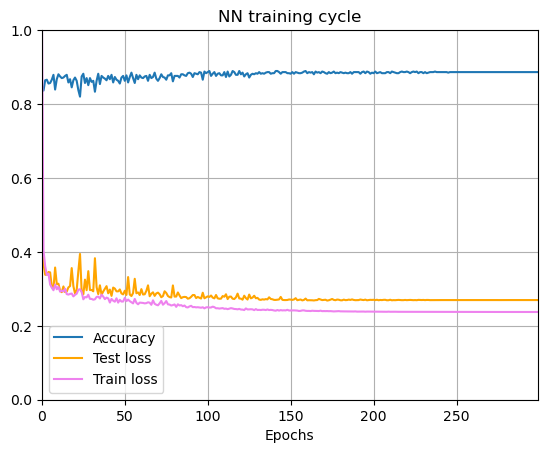

In [53]:
#plot the training cycle
plt.plot(result_arr1[:,0],result_arr1[:,3],linestyle='-', label='Accuracy')
plt.plot(result_arr1[:,0],result_arr1[:,2],linestyle='-', c='orange',label='Test loss')
plt.plot(result_arr1[:,0],result_arr1[:,1],linestyle='-', c='violet',label='Train loss')
plt.ylim(0,1)
plt.xlim(0,num_epochs-1)
plt.title('NN training cycle')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

In [54]:
print(r'Final accuracy is {}'.format(result_arr1[-1,3]))

Final accuracy is 0.8864306784660767


# Confusion matrix

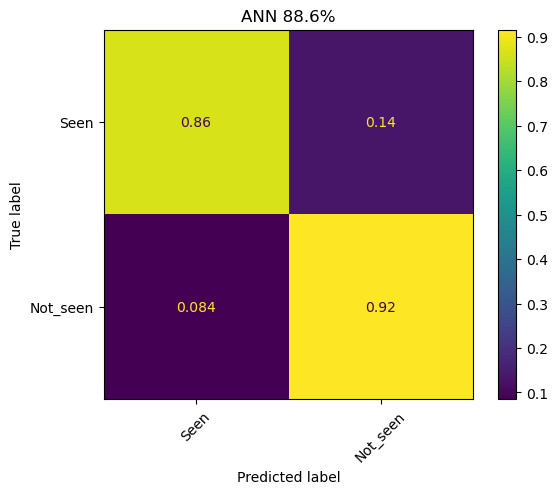

In [55]:
#plot the confusion matrix
cm = confusion_matrix(target, prediction,normalize = 'true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ptype)
disp.plot(xticks_rotation=45)
fig = disp.figure_
plt.title(r"ANN {:.3}%".format(result_arr1[-1,3]*100))
plt.show()

# Averaging accuracy

In [56]:
#run the model 20 times to get an average accuracy
if REPEAT_ACCURACY:
    acc_array =[]
    for i in range(20):
        result_arr_temp,_,_ = run_func()
        final_acc = result_arr_temp[-1,3]
        acc_array.append(final_acc)
    accuracy_avg = np.mean(acc_array)
    accuracy_std = np.std(acc_array)
    print(r'The averaged accuracy is {:.3f} ± {:.3f}'.format(accuracy_avg,accuracy_std))